In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import pickle
from rich.progress import track

sns.set(color_codes=True, style="white")

### Load Data

In [2]:
folder_PCF = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/PCF-RNA"
os.chdir(folder_PCF)
p_files = [f for f in os.listdir(".") if f.endswith(".p")]
conditions = [f.split("PairCorr-DataDict-pooled-")[-1][:-2] for f in p_files]
conditions_ordered = [
    "FL_2x",
    "ActB_2x",
    "GAPDH_2x",
    "PB1_SPEN_2x",
    "PB2_CXCR2_2x",
    "THOR_2x",
    # "THORdel_2x",
    "SG1_AHNAK_2x",
    "SG2_DYNC1H1_2x",
    "SG3_NORAD_2x",
    "ActB_1x",
    "GAPDH_1x",
    "THOR_1x",
]
colors = [
    "#BD2433",  # FL
    "#9C1A27",  # ActB
    "#EB074B",  # GAPDH
    "#738DF5",  # PB1
    "#4C7AB5",  # PB2
    "#0F183D",  # THOR
    # "#245696",  # THORdel
    "#FF8C00",  # SG1
    "#FF7538",  # SG2
    "#E25822",  # SG3
    "#708090",  # ActB, 1x
    "#8C92AC",  # GAPDH, 1x
    "#90A4AE",  # THOR, 1x
]
rna_length_kb = [
    1.7,  # FL
    1.8,  # ActB
    1.3,  # GAPDH
    12.4,  # PB1
    2.7,  # PB2
    0.6,  # THOR
    # "#245696",  # THORdel
    17.5,  # SG1
    19.9,  # SG2
    5.3,  # SG3
]

### Functions

In [3]:
def weighted_stats(lst_PCF_per_cell, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_cell[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array([lst_PCF_per_cell[j][i] for j in range(N_condensates)])
        # remove nan
        mask = np.isnan(data_array) | np.isnan(weights)
        data_array = data_array[~mask]
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights[~mask])
        # calculate the variance
        variance = np.average(
            (data_array - weighted_mean[i]) ** 2, weights=weights[~mask]
        )
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def cluster_model(r, A, r0):
    # r0 is the characteristic size of clustering
    Gr = 1 + A * np.exp(-r / r0)
    return Gr


def coscos_PCF(r, a1, b1, c1, a2, b2, c2, d):
    # a is amplitude
    # b is wave number, also called the angular frequency
    # c is phase shift
    # d is vertical shift or rest position
    Gr = a1 * np.cos(b1 * r + c1) + a2 * np.cos(b2 * r + c2) + d
    return Gr


def red_chi(bins, A, r0, weighted_mean, weighted_std):
    # Calculate chi square
    Gr_fitted = cluster_model(bins, A, r0)
    residuals = weighted_mean - Gr_fitted
    variance = weighted_std**2
    chi_square = np.sum((residuals**2) / variance)
    # Calculate degrees of freedom
    dof = len(bins) - 2
    # Calculate reduced chi square
    reduced_chi_square = chi_square / dof
    return reduced_chi_square


def bootstrap(bins, lst_PCF_per_cell, lst_N_locations, bs_size=30, bs_rounds=100):
    lst_A = []
    lst_r0 = []
    lst_red_chi2 = []
    for i in range(bs_rounds):
        idxs = np.random.choice(len(lst_PCF_per_cell), bs_size)
        lst_PCF_bs = [lst_PCF_per_cell[idx] for idx in idxs]

        idxs = np.random.choice(len(lst_N_locations), bs_size)
        lst_N_bs = [lst_N_locations[idx] for idx in idxs]

        weighted_mean, _, weighted_std = weighted_stats(lst_PCF_bs, lst_N_bs)

        popt, _ = curve_fit(
            cluster_model,
            bins[1:],
            weighted_mean[1:],
            bounds=([-2, 0], [2, 2000]),
            maxfev=10000,
        )
        A, r0 = popt
        reduced_chi_square = red_chi(
            bins[1:], A, r0, weighted_mean[1:], weighted_std[1:]
        )

        lst_A.append(A)
        lst_r0.append(r0)
        lst_red_chi2.append(reduced_chi_square)

    return lst_A, lst_r0, lst_red_chi2

### cross weighted mean + STD

In [4]:
lst_mean = []
lst_sem = []
for i in track(range(len(conditions_ordered))):
    condition = conditions_ordered[i]
    dict_toplot = pickle.load(
        open("PairCorr-DataDict-pooled-" + condition + ".p", "rb")
    )
    nm_per_pxl = dict_toplot["nm_per_pxl"]
    r_max_nm = dict_toplot["r_max_nm"]
    ringwidth_nm = dict_toplot["ringwidth_nm"]
    dr_slidingrings_nm = dict_toplot["dr_slidingrings_nm"]
    bins = dict_toplot["bins"]

    # Calculate the weighted mean, STD, SEM
    lst_PCF_per_cell = dict_toplot["lst_cross"]
    lst_N_loc_condensate = dict_toplot["lst_N_loc_condensate"]
    lst_N_loc_RNA = dict_toplot["lst_N_loc_RNA"]
    lst_PCF_per_cell_norm = []
    lst_N_locations = []
    for current_PCF, a, b in zip(lst_PCF_per_cell, lst_N_loc_condensate, lst_N_loc_RNA):
        if np.mean(current_PCF[-10:]) == 0:
            continue
        lst_PCF_per_cell_norm.append(current_PCF / np.mean(current_PCF[-10:]))
        lst_N_locations.append(a + b)

    weighted_mean, weighted_sem, weighted_std = weighted_stats(
        lst_PCF_per_cell_norm, lst_N_locations
    )
    lst_mean.append(weighted_mean[0])
    lst_sem.append(weighted_sem[0])



Output()

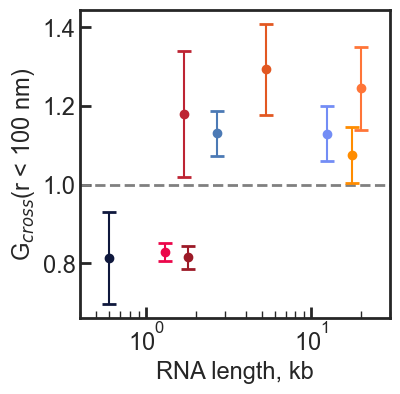

In [19]:
plt.figure(figsize=(4, 4))
# lines for eyes
plt.axhline(1, c="gray", ls="--", lw=2)
# plot
for i in range(len(rna_length_kb)):
    plt.errorbar(
        rna_length_kb[i],
        lst_mean[i],
        yerr=lst_sem[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.xlabel("RNA length, kb", fontsize=17)
plt.ylabel(r"G$_{cross}$(r < 100 nm)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=8,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="minor",
    direction="in",
    bottom=True,
    length=5,
    width=1,
)
plt.xscale("log")
plt.xlim(0.4, 30)
plt.savefig(
    "doterrorplot_PCF_vs_RNAlength.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)